In [176]:
import os 
import numpy as np
from scipy.stats import rankdata 
import matplotlib.pyplot as plt
lstDataset = os.listdir("tcp")
OptRes = [21282, 20749, 50778]
def LeerDataset(dataset):
    f = open(f"tcp/{dataset}", "r")
    lineas = f.readlines()[6:-1]
    return [( int(float(l.split()[1])) , int(float(l.split()[2])) ) for l in lineas]

def geometric(prob):
    return np.random.geometric(prob)

class Nodo:
      dic_dis = {}
      TAG = 0
      def __init__(self, x, y) -> None:
            self.Tag = Nodo.TAG
            Nodo.TAG += 1
            self.X = x
            self.Y = y
      def dis_to(self, nodo: 'Nodo'):
            proto_dis = Nodo.dic_dis.get((self.Tag, nodo.Tag), -1)
            if proto_dis == -1:
                  Nodo.dic_dis[(self.Tag, nodo.Tag)] = np.sqrt( (self.X - nodo.X)**2 + (self.Y - nodo.Y)**2 )
                  Nodo.dic_dis[(nodo.Tag, self.Tag)] = np.sqrt( (self.X - nodo.X)**2 + (self.Y - nodo.Y)**2 )
            return Nodo.dic_dis[(self.Tag, nodo.Tag)]
            
class Ruta:
    def __init__(self, data, optimo, ng = 3000, npop = 1000, ngenes = None) -> None:
        self.lstNodos = [Nodo(n[0],n[1]) for n in LeerDataset(data)]
        self.RutaOptima = None
        self.NG = ng
        self.NPOP = npop
        self.N_GENES = len(self.lstNodos) if ngenes == None else ngenes
        self.X_BOUND = [0, 300*self.N_GENES]
        self.OPTIMO = optimo

        self.SELPBST = 0.85
        self.SELPWST = 0.02
        self.GEOPCTI = 0.7
        #Crear poblacion inicial
        self.POP = np.random.randint(self.X_BOUND[1], size=(self.NPOP, self.N_GENES))

    def RankPOP(self, X):
        return np.row_stack([rankdata(P).astype(int) for P in X])
             
    def Torneo(self,X, fenotipos):
        ganadores = np.zeros_like(X)
        for i in range(0,self.NPOP,2):
            ip = min(i+1, self.NPOP - 1)
            if fenotipos[i] < fenotipos[ip]:    
                w = X[i]
                l = X[ip]
            else:
                w = X[ip] 
                l = X[i]
            ra = np.random.rand()
            rw = np.random.rand()
            if rw <= self.SELPWST:
                ganadores[i] = l
                ganadores[ip] = self.mutg_ipop(w) if ra <= self.SELPBST else w
            else:
                ganadores[i] = w
                ganadores[ip] = self.mutg_ipop(w) if ra <= self.SELPBST else l
        return ganadores
    def Fi(self, Xi):
        Xir = Xi - 1
        distancia = 0
        #print(Xir)
        for i in range(self.N_GENES - 2): #recorrer todas las ciudades , -1 porque cuenta desde 0
              tag = Xir[i]
              p_tag = Xir[i + 1]
              #print(tag, p_tag)
              distancia += self.lstNodos[tag].dis_to(self.lstNodos[p_tag])
        distancia += self.lstNodos[Xir[0]].dis_to(self.lstNodos[Xir[-1]]) #regresar a la primera ciudad
        return distancia
    def F(self, X):
      res = []
      for Xi in self.RankPOP(X):
            res.append(self.Fi(Xi))
      return res
    
    def mutg_ipop(self, Xi, p = None, m = None):
        XiOri = Xi.copy()
        if m is None:
            m = geometric(self.GEOPCTI) + 1
        if p is None:
            p = np.random.randint(self.N_GENES, size=m)
            p.sort()
            
        if m > 1:
            # Crear la nueva ruta atemp copiando el segmento envolvente de p
            mleft = m - 1
            while mleft > 0:
                izq = p[m - mleft - 1]
                der = p[m - mleft]
                #print(izq,der)
                segmento = Xi[izq:der]
                if np.random.randint(10) % 2 == 0:
                    # Agregar la siguiente pieza en dirección normal
                    Xi[izq:der] = segmento
                else:
                    # Agregar la siguiente pieza en dirección inversa
                    Xi[izq:der] = segmento[::-1]
                mleft -= 1
            # Retornar la nueva ruta mutada
        #error = (self.Fi(rankdata(Xi).astype(int)) - self.OPTIMO) / self.OPTIMO * 100
        if (self.GEOPCTI > 0.95): #Realizar una sobrebusqueda
            if self.Fi(rankdata(Xi).astype(int)) < self.Fi(rankdata(XiOri).astype(int)):
                mm = 4
                
                izp = max(0, p[0] - 5)
                dep = min(self.N_GENES - 1, p[-1] + 5)
                pp = np.random.randint(izp, dep, size=mm)
                pp.sort()
                pp[0] = izp
                pp[-1] = dep
                
                #if presion > 0:
                #print(f"sobrepresion {presion} | {p} -> {pp}")
                return self.mutg_ipop(Xi, p = pp, m = mm)
        return Xi

    def Entrenar(self, resultados = None):
        ultimos = [0] * 10
        for generacion in range(self.NG):
            fenotipos = self.F(self.POP)
            #print(fenotipos)
            error = (min(fenotipos) - self.OPTIMO) / self.OPTIMO * 100
            if generacion%1000 == 0: print(f"Para la generacion {generacion} hay una error de {error}% con GEOPCTI {self.GEOPCTI}")
            resultados.append(error)
            ultimos.append(error)
            ultimos.pop(0)
            if generacion%100 == 0: 
                if (abs(np.average(ultimos) - error) > 0.5):
                    self.GEOPCTI = max(0.7, self.GEOPCTI - 0.01)
                else:
                    self.GEOPCTI = min(0.98, self.GEOPCTI + 0.01)
                #print(self.GEOPCTI)
            #Torneo simple
            Ganadores = self.Torneo(self.POP, fenotipos)            
            np.random.shuffle(Ganadores)
            self.POP = Ganadores
        print(f"Para la ultima generacion {self.NG} hay una error de {error}%")


Ejecutando el dataset : KROA100
Para la generacion 0 hay una error de 634.5570903576912% con GEOPCTI 0.7
Para la generacion 1000 hay una error de 84.04481343143138% con GEOPCTI 0.7
Para la generacion 2000 hay una error de 23.24896989009966% con GEOPCTI 0.77
Para la generacion 3000 hay una error de 15.726007192364222% con GEOPCTI 0.8700000000000001
Para la generacion 4000 hay una error de 8.99348542503019% con GEOPCTI 0.9500000000000002
Para la generacion 5000 hay una error de 8.72172484697184% con GEOPCTI 0.98
Para la generacion 6000 hay una error de 8.348676757668505% con GEOPCTI 0.98
Para la generacion 7000 hay una error de 7.714721044461292% con GEOPCTI 0.98
Para la ultima generacion 8000 hay una error de 6.198759071735815%
Ejecutando el dataset : KROC100
Para la generacion 0 hay una error de 636.0940253118628% con GEOPCTI 0.7
Para la generacion 1000 hay una error de 86.63143249891573% con GEOPCTI 0.72
Para la generacion 2000 hay una error de 32.40452409693764% con GEOPCTI 0.8
Para 

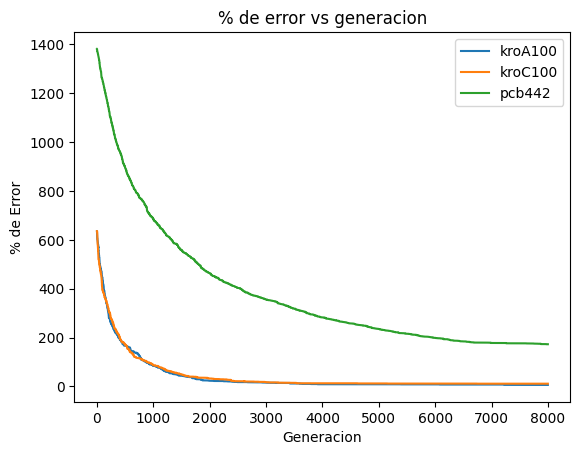

In [177]:
plt.title("% de error vs generacion")
plt.ylabel("% de Error")
plt.xlabel("Generacion")
lstRes = []
for i in range(3):
    NombreDataset = lstDataset[i].replace(".tsp","")
    print(f"Ejecutando el dataset : {NombreDataset.upper()}")
    R1 = Ruta(lstDataset[i], OptRes[i], npop=30, ng=8000)
    lstResultados_i = []
    R1.Entrenar(resultados = lstResultados_i)
    lstRes.append(lstResultados_i)
    plt.plot(lstResultados_i, label = NombreDataset)
    plt.legend()
plt.show()